# Dan Crouthamel – SMU NLP Course — Homework 2

## Assignment Objectives

1. In Python, create a method for scoring the vocabulary size of a text, and normalize the score from 0 to 1. It does not matter what method you use for normalization as long as you explain it in a short paragraph. (Various methods will be discussed in the live session.)

2. After consulting section 3.2 in chapter 1 of Bird-Klein, create a method for scoring the long-word vocabulary size of a text, and likewise normalize (and explain) the scoring as in step 1 above.

3. Now create a “text difficulty score” by combining the lexical diversity score from homework 1, and your normalized score of vocabulary size and long-word vocabulary size, in equal weighting. Explain what you see when this score is applied to same graded texts you used in homework 1.

## Solution

We'll start by reusing the code from HW 1 and modify it to support the objectives above. Our lexical diversity scoring function already computes vocab size. We'll update it to include the long word count and return it as another item in the tuple.

We'll then use a "normalization" function to normalize vocab size and long word count across all books. Note, for the purpose of this exercise I chose long words to be words with more than 12 characters. Just as we did for vocab size, we'll use 'set' on long word count to remove duplicates. That is, if I have 10 long words, each identitical, it will have a count of 1.

Finally, some additional tweaks are being made to clean up our tokens prior to computing the scores.

* Convert raw book text to lower case
* Exclude Stop Words
* Exclude non-alpha

I'm excluding non-alpha so that we compare words, as opposed to symbols, like '[', etc. I don't think there is a right or wrong here. What tokens we include is really dependent up on what problem we are trying to solve.

Important! In HW1 I defined lexical diversity as word count / vocab size. In my analysis below, I will include the inverse of that as well. I found that when using it in the definition of text difficulty score, that it also trends nicely with grades. Also, the first edition of the NLTK book had defined lexical diversity as word count / vocab size, but then changed it in a later version to vocab size / word count.

### Library Imports

In [1]:
from __future__ import division  
# Import and download nltk
import nltk
import requests
import urllib
import matplotlib.pyplot as plt
import nltk, re, pprint
from nltk import word_tokenize
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from nltk.corpus import stopwords
from sklearn.preprocessing import minmax_scale
from tabulate import tabulate

### Lexical Diversity Scoring Function

This function will return a tuple of four values.

* Lexical Diversity Score = Word Count / Total Number of Unique Words (Vocabulary Size)
* Vocabulary Size
* Total Word Count
* Long Word Count - words having more than 12 characters

Note, the function below is returning lexical diversity as defined above. If we were to calculate the inverse of this value, it would then represent lexical diversity as vocab size / word count. We will make use of the inverse as in our analysis as well.

In [2]:
# Return a tuple of values (lexical diversity, vocab size, word count, long word count)
def lexical_diversity(text):
    vocab_size = len(set(text))
    word_count = len(text)

    # *dcrouthamel - for HW2, we are adding in our check for Long words
    long_word_count = len(set([w for w in text if len(w) > 12]))

    # *dcrouthamel - I'm still unsure of what definition to use here
    #                I'll stick with what I did in HW1, and take inverse later in analysis
    score = word_count / vocab_size
    #score = vocab_size /  word_count

    return score, vocab_size, word_count, long_word_count

### Normalization Function

This function will take a list of score values and then use Sklearn's minmax_scale function to normalize the scores between 0 and 1. The parameter should be a list of scores (e.g., vocab size, for each reader book - 6 of them).

Examples for normalization. Suppose we had a list of '1, 2, 3'. The normalize_scores function below would return '0, .5, 1'. If the input was '1, 2, 3, 4' it would return '0, .33, .66, 1'.

In [3]:
def normalize_scores(scores):
    return(minmax_scale(np.array(scores), feature_range=(0,1), axis=0))

### List of Book Dictionary Objects

Here we'll load McGuffey's Eclectic Readers, Grades 1 through 6. We will store each book in a list, with each book being a dictionary object containing:

* Url to load from
* Grade
* Lexical Diversity scores
* Raw text loaded from Url
* Tokens

In [4]:
# Create a list of dictionary book objects
books = []

book1 = {'url': 'http://www.gutenberg.org/ebooks/14640.txt.utf-8',
         'name': 'Grade1'}

book2 = {'url': 'http://www.gutenberg.org/ebooks/14668.txt.utf-8',
         'name': 'Grade2'}

book3 = {'url': 'http://www.gutenberg.org/ebooks/14766.txt.utf-8',
         'name': 'Grade3'}

book4 = {'url': 'http://www.gutenberg.org/ebooks/14880.txt.utf-8',
         'name': 'Grade4'}

book5 = {'url': 'http://www.gutenberg.org/ebooks/15040.txt.utf-8',
         'name': 'Grade5'}

book6 = {'url': 'http://www.gutenberg.org/ebooks/16751.txt.utf-8',
         'name': 'Grade6'}

books = [book1, book2, book3, book4, book5, book6]

# *dcrouthamel - For HW2, going to use stopwords
stopwords = nltk.corpus.stopwords.words('english')

# *dcrouthamel - For HW2, going to use a regular expression tokenization. Here is the pattern
#                we will use from the NLTK book
pattern = r'''(?x)     # set flag to allow verbose regexps
(?:[A-Z]\.)+       # abbreviations, e.g. U.S.A.
| \w+(?:-\w+)*       # words with optional internal hyphens
| \$?\d+(?:\.\d+)?%? # currency and percentages, e.g. $12.40, 82%
| \.\.\.             # ellipsis
| [][.,;"'?():-_`]   # these are separate tokens; includes ], [
'''

for book in books:
    # Read in raw text
    # *dcrouthamel - Change for HW2, we will convert this to lower case
    book['raw'] = urllib.request.urlopen(book['url']).read().decode('utf-8').lower()

    # Convert to tokens
    # *dcrouthamel - Change for HW2, we will use a regular expression version found in the NLTK book
    #book['tokens'] = nltk.word_tokenize(book['raw'])
    book['tokens'] = nltk.regexp_tokenize(book['raw'], pattern)

    # *dcrouthamel - Change for HW2, let's get rid of tokens that aren't words
    book['tokens'] = [w for w in book['tokens'] if w.isalpha()]

    # *dcrouthamel - Change for HW2, exclude stopwords, or those words with little lexical value
    book['tokens'] = [w for w in book['tokens'] if w.lower() not in stopwords]

    
    # Convert to NLTK text -- I don't think I need this yet
    #book['txt'] = nltk.Text(book['tokens'])

    # *dcrouthamel - HW2, moved further below
    # Compute scores
    #book['score'] = lexical_diversity(book['tokens'])

### Computing Scores, Sizes, and Normalized Values

Below we will create lists for the below values for each of the 6 reader books.

* Vocab Sizes
* Word Count
* Long Word Count
* Lexical Diversity
* Inverse Lexical Diversity

Next we will normalize lexical diverity, vocab size and long word count. Note, I did not normalize the inverse of lexical diversity since it's a number between 0 and 1 already.

We will then create two text difficulty scores, to cover both lexical diversity and its inverse, which again is a representation of word count / vocab size, and vocab size / word count, respectively. 

Finally, a table and some charts are produced for analysis.

In [5]:
# Remmber that book['score'] is a tuple of 4 values
for book in books:
    book['score'] = lexical_diversity(book['tokens'])

lex_div_score = [book['score'][0] for book in books]
inv_lex_div_score = [1 / book['score'][0] for book in books]
vocab_size = [book['score'][1] for book in books]
word_count = [book['score'][2] for book in books]
labels = [book['name'] for book in books]

# *dcrouthamel - For HW2
long_word_count = [book['score'][3] for book in books]

# Now compute the normalized values
norm_lex_div_score = normalize_scores(lex_div_score)
norm_vocab_size = normalize_scores(vocab_size)
norm_long_word_count = normalize_scores(long_word_count)

# Create Text Difficulty Score
text_difficulty_score = [sum(x) for x in zip(norm_lex_div_score, norm_vocab_size, norm_long_word_count)]
inv_text_difficulty_score = [sum(x) for x in zip(inv_lex_div_score, norm_vocab_size, norm_long_word_count)]

# Create a dataframe of scores and normalized values
columns =['Grade', 'Word Count', 'Vocab Size', 'Long Word Count', 'Lexical Diversity', 'Inverse Lexical Diversity',
          'Norm. Vocab Size', 'Norm. Long Word Count', 'Norm. Lexical Diversity', 'Text Difficulty Score', 'Inverse Text Difficulty Score']

df_scores = pd.DataFrame(list(zip(labels, word_count, vocab_size, long_word_count, lex_div_score, inv_lex_div_score,
                norm_vocab_size, norm_long_word_count, norm_lex_div_score, text_difficulty_score, inv_text_difficulty_score)),
               columns = columns)

pd.options.display.float_format = "{:,.2f}".format
#print(df_scores.transpose().to_markdown())
df_scores.transpose()

,0,1,2,3,4,5
Grade,Grade1,Grade2,Grade3,Grade4,Grade5,Grade6
Word Count,5830,10922,14654,33222,51055,71468
Vocab Size,1629,3082,3582,8004,11060,13681
Long Word Count,16,21,17,56,142,243
Lexical Diversity,3.58,3.54,4.09,4.15,4.62,5.22
Inverse Lexical Diversity,0.28,0.28,0.24,0.24,0.22,0.19
Norm. Vocab Size,0.00,0.12,0.16,0.53,0.78,1.00
Norm. Long Word Count,0.00,0.02,0.00,0.18,0.56,1.00
Norm. Lexical Diversity,0.02,0.00,0.33,0.36,0.64,1.00
Text Difficulty Score,0.02,0.14,0.49,1.07,1.98,3.00


### Analysis and Conclusion

In the table above, we see that our Text Difficulty Score, as well as its inverse trends nicely with grades, as we saw in HW1 with Lexical Diversity Score. But recall that lexical diversity was defined as word count / vocab size. If we use the new version and instead look at the Inverse Text Difficult Score, we see that also trends well with grades.

The 1st graph below shows something similar to HW1 as well, where we saw the lexical diversity score (blue dots) for grades 3 and 4 being pretty close together. By including a long word count feature (red dots), we see that Grade 3 is now pushed down with respect to Grade 4 since Grade 3 has a lot less long words compared to Grade 4. Therefore, our Text Difficulty Score may be a better measure to use.

Note, all of this is dependent upon what tokens we decides to use from our reader books. In this case all tokens were converted to lower case and only alpha type tokens were used, as previously mentioned above.

Below we also present a second graph, this time comparing Text Difficulty Score (LD = Word Count / Vocab Size) vs Text Difficulty Score (LD = Vocab Size / Word Count). Here we see that both perform relatively the same.

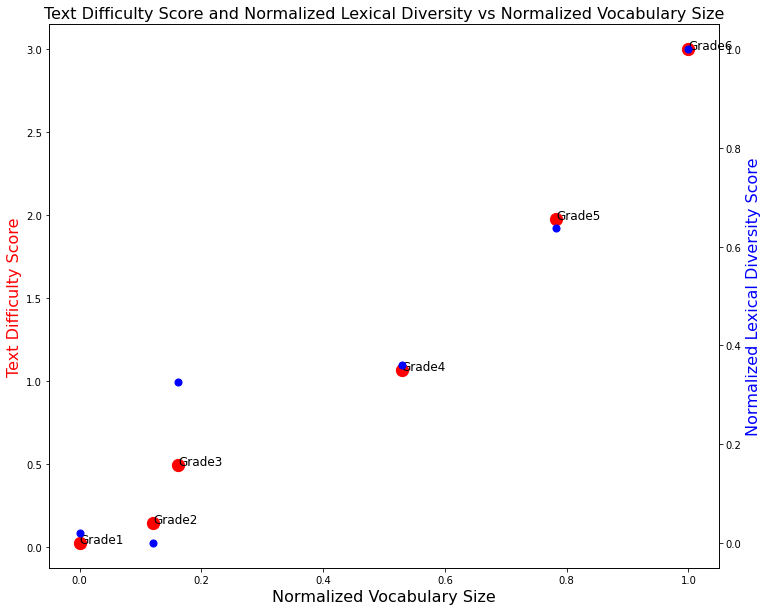

In [6]:
fig,ax = plt.subplots()
fig.set_size_inches(12, 10)
# Note, we will make the red dots bigger than the blue
ax.scatter(norm_vocab_size, text_difficulty_score, s=150, color='red')
#ax.scatter(norm_vocab_size, inv_text_difficulty_score, s=150, color='red')

ax.set_xlabel('Normalized Vocabulary Size', fontsize=16)
ax.set_ylabel('Text Difficulty Score', color='red', fontsize=16)

ax2 = ax.twinx()
ax2.scatter(norm_vocab_size, norm_lex_div_score, s=50, color='blue')
#ax2.scatter(norm_vocab_size, inv_lex_div_score, s=50, color='blue')
ax2.set_ylabel('Normalized Lexical Diversity Score', color='blue', fontsize=16)

for i, label in enumerate(labels):
    ax.annotate(label, (norm_vocab_size[i], text_difficulty_score[i]), fontsize=12)
    #ax.annotate(label, (norm_vocab_size[i], inv_text_difficulty_score[i]), fontsize=12)

plt.title('Text Difficulty Score and Normalized Lexical Diversity vs Normalized Vocabulary Size', fontsize=16)
plt.show()

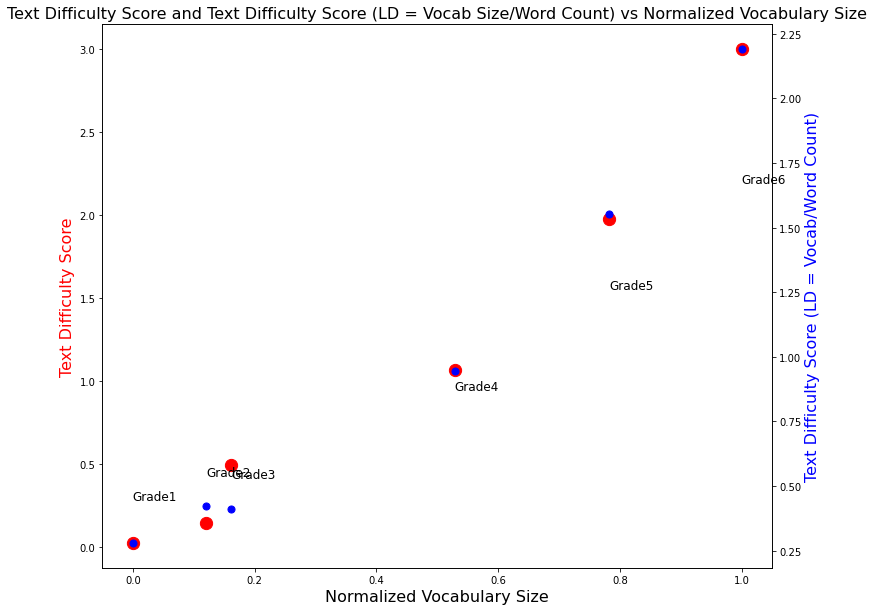

In [7]:
fig,ax = plt.subplots()
fig.set_size_inches(12, 10)
# Note, we will make the red dots bigger than the blue
ax.scatter(norm_vocab_size, text_difficulty_score, s=150, color='red')

ax.set_xlabel('Normalized Vocabulary Size', fontsize=16)
ax.set_ylabel('Text Difficulty Score', color='red', fontsize=16)

ax2 = ax.twinx()
ax2.scatter(norm_vocab_size, inv_text_difficulty_score, s=50, color='blue')
ax2.set_ylabel('Text Difficulty Score (LD = Vocab/Word Count)', color='blue', fontsize=16)

for i, label in enumerate(labels):
    ax.annotate(label, (norm_vocab_size[i], inv_text_difficulty_score[i]), fontsize=12)

plt.title('Text Difficulty Score and Text Difficulty Score (LD = Vocab Size/Word Count) vs Normalized Vocabulary Size', fontsize=16)
plt.show()

### Scratch Code - Ignore

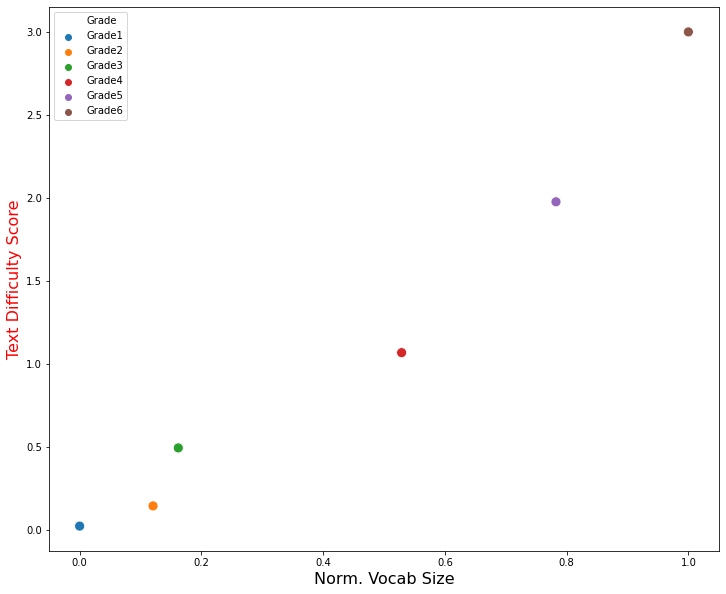

In [8]:
import seaborn as sns

fig,ax = plt.subplots()
fig.set_size_inches(12, 10)
#sns.lineplot(data=df.column1, color="g")
#ax2 = plt.twinx()
#sns.lineplot(data=df.column2, color="b", ax=ax2)

ax.set_xlabel('Normalized Vocabulary Size', fontsize=16)
ax.set_ylabel('Text Difficulty Score', color='red', fontsize=16)

sns.scatterplot(data=df_scores, x=df_scores['Norm. Vocab Size'], y=df_scores['Text Difficulty Score'], hue=df_scores['Grade'], ax=ax, s=100)
plt.show()